In [1]:
import sys

sys.path.append("..")

import yaml
import numpy as np
import matplotlib.pyplot as plt
from src.environments import ea

# RL4AA Tutorial -- Part 1

Goal: Solve the ARES Experimental Area tuning problem in a standard setting.

In [2]:
# Create the Environment
# TODO: Move this part to a utility function later

from gymnasium.wrappers import TimeLimit, FlattenObservation, RescaleAction
from src.wrappers import RecordEpisode, RescaleObservation


def make_eval_env(config: dict):
    wrapper_config = config["env_wrapper"]
    env = ea.TransverseTuning(**config["env"])

    env = TimeLimit(env, max_episode_steps=wrapper_config["max_episode_steps"])
    env = RecordEpisode(env)
    if wrapper_config["normalize_observation"]:
        env = RescaleObservation(env, 0, 1)
    if wrapper_config["rescale_action"]:
        env = RescaleAction(env, -1, 1)
    env = FlattenObservation(env)
    return env

In [3]:
config = yaml.safe_load(open("../config/ea_eval_config.yaml", "r"))

env = make_eval_env(config)

In [4]:
env.reset()

(array([3.6796455 , 4.1047115 , 0.9648144 , 0.19523343, 0.18531075,
        0.27844745, 0.8176104 , 0.2145333 , 0.5664935 , 0.5       ,
        0.        , 0.5       , 0.        ], dtype=float32),
 {'binning': array(1),
  'is_on_screen': False,
  'pixel_size': array([3.3198e-06, 2.4469e-06], dtype=float32),
  'screen_resolution': array([2448., 2040.]),
  'magnet_names': ['AREAMQZM1',
   'AREAMQZM2',
   'AREAMCVM1',
   'AREAMQZM3',
   'AREAMCHM1'],
  'screen_name': 'AREABSCR1',
  'beam_reward': None,
  'on_screen_reward': None,
  'magnet_change_reward': None,
  'backend_info': {'incoming_beam': array([ 1.0140050e+08,  6.3369895e-04, -5.1670620e-05,  4.5974180e-04,
          -3.0431343e-05,  4.2834834e-04,  1.9168965e-05,  4.8964191e-04,
           5.4929465e-06,  4.4421968e-06,  5.6506909e-04], dtype=float32),
   'misalignments': array([-2.0561318e-05,  1.7460827e-05, -6.7109155e-05,  7.0289789e-05,
          -9.9992969e-05, -7.4051997e-05, -5.9633945e-05,  7.4094787e-05],
         dtyp

In [5]:
env.unwrapped.get_beam_difference(metric="mae")
unwrapped_env = env.unwrapped

## The EA Tuning Task Setup

Observation:

Actions:


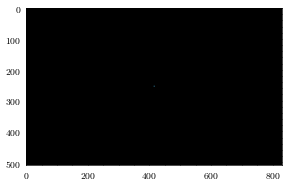

In [6]:
plt.imshow(unwrapped_env.render())

## Trying to solve the EA problem

Implement a controller or optimization method, that can bring the observed electron beam $\bm{b}$ to the target beam parameters $\bm{b}'$.

The difference between the beam parameters can be characterized by the mean absolute error (MAE):

$$
d_\text{MAE} (\bm{b}, \bm{b}') = \frac{1}{4} \sum_{i=1}^{4} |\bm{b}_i - \bm{b}'_i|
$$

The algorithm is allowed to interact with the environment for in total $T$ steps. ($T=200$ in this example)

The performance of the method will be evaluated by the following metrics:

- Best MAE achieved by the method $\min d_i, i=1,\dots, T$
- Cumulated MAE differences over the episode $\sum_{i=1}^{T} d_i$

### Baseline Method

To help you get started, below we provide a simple example with the Nelder-Mead optimizer to show how to interact with the env.

In [7]:
# Here we provide the baseline Nelder-Mead simplex Method
from scipy.optimize import minimize


# Wrap the env interaction in an objective function for optimization
def objective(x):
    env.step(x)
    return env.unwrapped.get_beam_difference(metric="mae")


# Reset the Environment
obs, _ = env.reset()

x0 = obs[4:9]

res = minimize(
    objective,
    x0,
    method="nelder-mead",
    options={
        "xatol": 1e-8,
        "disp": True,
        "maxfev": config["env_wrapper"][
            "max_episode_steps"
        ],  # Maximum number of function evaluations
    },
)

/var/folders/35/tl4qn9hx1c59cv7hmzsrrbd00000gn/T/ipykernel_4556/3673414813.py:16: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


## Look into the result

TODO: Move the following part in a utility function and hide from participants

Minimum MAE:                -3.139  mm
Sum of MAE over all steps:  127.922 mm


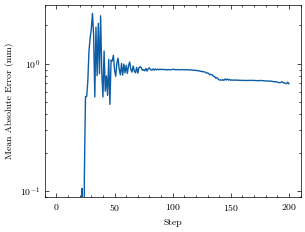

In [8]:
observations = env.get_wrapper_attr("observations")

maes = np.array([np.mean(obs["beam"] - obs["target"]) for obs in observations])

plt.plot(maes * 1000)
# set y to logscale
plt.yscale("log")
plt.ylabel("Mean Absolute Error (mm)")
plt.xlabel("Step")

print(f"Minimum MAE:                {min(maes) * 1000:.3f}  mm")
print(f"Sum of MAE over all steps:  {np.sum(maes) * 1000:.3f} mm")

### Now it is time to develop your own controller!



## Development Ideas:

In the challenge, 

- Have a utility function to prepare the basic env setup (should not be modified) (cheetah backend, magnet range, ...)
  - The users can change the 
  - 
- Create a new env wrapper to log the necessary statistics for the evaluation, e.g.
  - MAEs over steps
  - Wall-time used for each step
- Evaluation Script that runs the control on several tasks and save the results
  - Use argparse to decide which tasks to load, we provide the `train_tasks` in the beginning
  - In the end, we provide the `test_tasks` for the final evaluation
